In [1]:
!pip install ISLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(55)

# Load the Abalone dataset
df = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')

# One-hot encoding for 'Sex'
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

# Separate features and target
design = MS(df.columns.drop(['Rings', 'id'])).fit(df)
D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
#X = design.transform(df)
Y = df['Rings']

# Apply PCA
pca = PCA(random_state=55)
Xs = X - X.mean(0)[None, :]
X_scale = X.std(0)
Xs = Xs / X_scale[None, :]
X_pca = pca.fit_transform(Xs)
# Choose number of components (e.g., 95% variance)
explained_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_var >= 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
  

Selecting the Number of Principal Components, based on explained variance (95%)

In [2]:
pca = PCA(n_components=n_components, random_state=55)
scaler = StandardScaler(with_mean=True, with_std=True)
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(Xs, Y)
pcr_model = pipe.named_steps['linreg']
print(pcr_model.coef_)

[ 0.76846626 -0.01539685 -0.52737193]


In [3]:
# Regression Coefficients for PCs
pcr_coeffs = pipe.named_steps['linreg'].coef_
print("PCR Coefficients (for each Principal Component predicting Rings):")
for i, coeff in enumerate(pcr_coeffs):
    print(f"PC{i+1}: {coeff:.4f}")

PCR Coefficients (for each Principal Component predicting Rings):
PC1: 0.7685
PC2: -0.0154
PC3: -0.5274


PCi coefficients show how Rings changes for a one-unit change in PCi

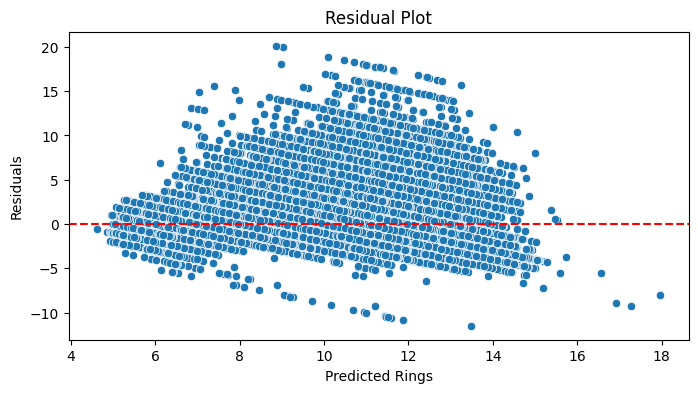

In [4]:
# Predictions
y_pred = pipe.predict(Xs)
y_pred = np.maximum(0, y_pred)

residuals = Y - y_pred

# Residual plot
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Scatter pattern around the red line rejects linearity, and funnel shape rejects constant spread (homoscedasticity).

In [5]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw:.2f}')

Durbin-Watson statistic: 1.99


DW ≈ 2 → no autocorrelation.  
DW < 1.5 → positive autocorrelation.  
DW > 2.5 → negative autocorrelation.

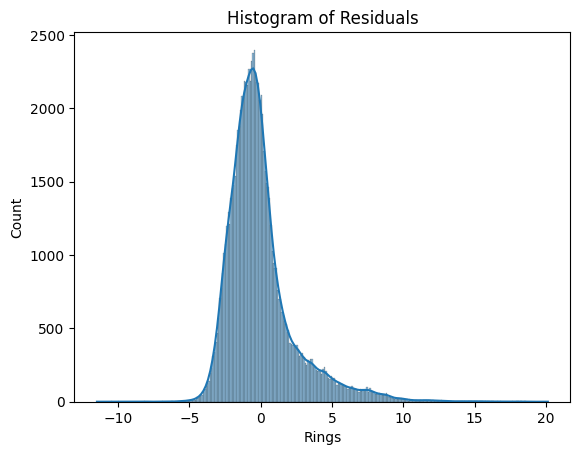

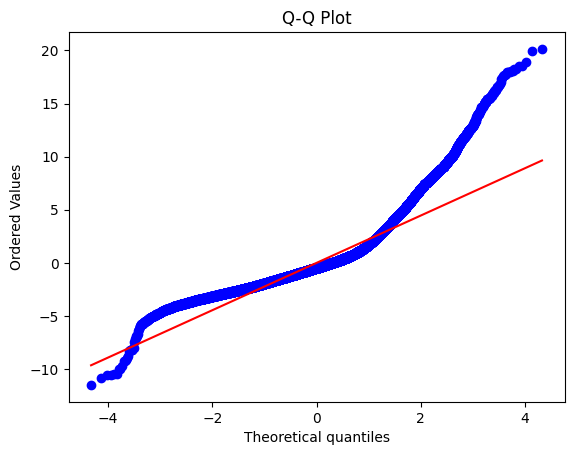

In [6]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

Not all points fall on 45 degree red line, the normality assumption does not hold up.

In [7]:
# Check VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = D.columns
vif_data["VIF"] = [variance_inflation_factor(Xs, i) for i in range(Xs.shape[1])]
print(vif_data)

          feature        VIF
0          Length  51.208712
1        Diameter  54.291324
2          Height   7.813579
3    Whole weight  69.242348
4  Whole weight.1  21.463228
5  Whole weight.2  20.067845
6    Shell weight  18.339175
7           Sex_I   2.387746
8           Sex_M   1.442002


VIF > 5 → moderate multicollinearity.  
VIF > 10 → severe multicollinearity.

In [8]:
# --- Load test data ---
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")
test_ids = test_df["id"]
test_df = pd.get_dummies(test_df, columns=['Sex'], drop_first=True)
design2 = MS(test_df.columns.drop('id')).fit(test_df)
D2 = design2.fit_transform(test_df)
D2 = D2.drop('intercept', axis=1)
X_test = np.asarray(D2)
# --- Predict using Model ---
preds_pcr = pipe.predict(X_test)
preds_pcr = np.maximum(0, preds_pcr)

# --- Save submission files ---
submission = pd.DataFrame({'id': test_ids, 'Rings': preds_pcr})
submission.to_csv("/kaggle/working/submission_model1.csv", index=False)
print("Submissions saved: submission_model.csv")

Submissions saved: submission_model.csv
